<a href="https://colab.research.google.com/github/Arden-Zhu/fashion_net2/blob/master/DeepFashion_classifer_by_category_picked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import os
import time
import pandas as pd
import numpy as np
import PIL
from pathlib import Path

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.vision import *

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
my_drive_dir = "/content/gdrive/My Drive/Machine Learning"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
since = time.time()
dataset_root = os.path.join(my_drive_dir, 'Datasets\DeepFashion\Category and Attribute Prediction Benchmark'.replace('\\', '/'))
! tar xf "{dataset_root}/picked.tar" -C data/
print('%.3f' % (time.time() - since))

8.012


## list_category_img

In [6]:
file = os.path.join(dataset_root, 'picked.csv')
df = pd.read_csv(file, index_col=0)
df = df.loc[:, ['file', 'category_name', 'category_id']]
df['file'] = df.apply(lambda m: m.file[4:], axis=1)
df.head()

,file,category_name,category_id
23063,Kimono-Sleeved_Paisley_Blouse/img_00000121.jpg,Blouse,3
30780,Boxy_Chiffon_Pocket_Blouse/img_00000056.jpg,Blouse,3
13998,Crochet_Lace-Paneled_Blouse/img_00000035.jpg,Blouse,3
123023,New_York_City_Pocket_Tee/img_00000012.jpg,Tee,18
21889,Georgette_Tulip_Back_Blouse/img_00000029.jpg,Blouse,3


## ImageDataBunch

In [0]:
bs = 64

In [8]:
transforms =  get_transforms(max_zoom=1.05, max_warp=0.05, max_rotate=5)
transforms[0][0] = crop_pad(row_pct=(0.4, 0.6), col_pct=(0.4, 0.6))
# tfs = (tfs[0][1:], tfs[1])
transforms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0.4, 0.6), 'col_pct': (0.4, 0.6)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.05, 0.05)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-5, 5)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.05), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True

In [0]:
data = ImageDataBunch.from_df('data/data/picked', df, size=224, bs=bs, ds_tfms=transforms
                              ).normalize(imagenet_stats)

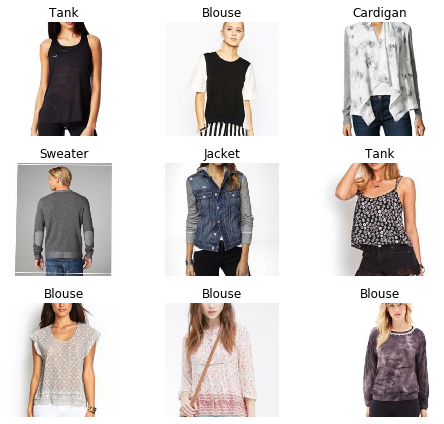

In [10]:
data.show_batch(rows=3, figsize=(7,6))

## Training: resnet34

In [11]:
learn_root = my_drive_dir + '/Fashionnet'
learn = cnn_learner(data, models.resnet34, metrics=error_rate, path=learn_root, model_dir='Classifer_picked/')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 92.7MB/s]


In [0]:
stage = 1
learn.fit_one_cycle(2)
learn.save('stage-' + str(stage))
# ! cp models/stage-{stage}.pth '{model_save_path}/'

epoch,train_loss,valid_loss,error_rate,time
0,1.531042,1.395575,0.483750,04:54
1,1.361895,1.300883,0.444500,04:57


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


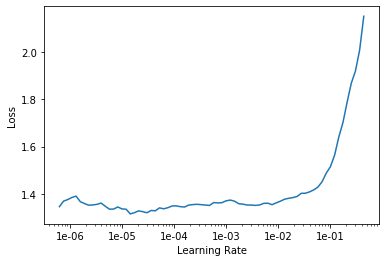

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
stage += 1
learn.fit_one_cycle(4, max_lr=1e-5)
s_stage = 'stage-%d' % stage
learn.save(s_stage)
print(s_stage)

epoch,train_loss,valid_loss,error_rate,time
0,1.314096,1.299095,0.444250,05:00
1,1.322662,1.294497,0.443125,04:51
2,1.308831,1.291478,0.441000,04:48
3,1.315611,1.292201,0.440625,04:44


In [0]:
'stage-%d' % stage

'stage-2'

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


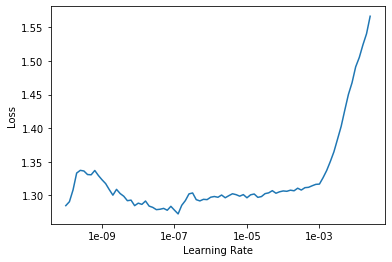

In [0]:
learn.unfreeze()
learn.lr_find(start_lr=1e-11, end_lr=1e-1)
learn.recorder.plot()

In [0]:
learn.load('stage-2')
learn.unfreeze()
for i in range(2):
  learn.fit_one_cycle(2, max_lr=9e-8)
learn.save('stage-3.0')

epoch,train_loss,valid_loss,error_rate,time
0,1.320024,1.291802,0.441000,04:41
1,1.327668,1.288725,0.440250,04:48


epoch,train_loss,valid_loss,error_rate,time
0,1.285563,1.289060,0.440375,04:35
1,1.303109,1.288420,0.440125,04:29


In [0]:
learn.load('stage-2')
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=9e-8)
learn.save('stage-3.1')

epoch,train_loss,valid_loss,error_rate,time
0,1.325753,1.291710,0.442000,04:44
1,1.323332,1.289751,0.441375,04:35
2,1.308377,1.286755,0.439500,04:33
3,1.322212,1.288639,0.439500,04:48


In [0]:
learn.load('stage-2')
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-8, 9e-8))
learn.save('stage-3.2')

epoch,train_loss,valid_loss,error_rate,time
0,1.313883,1.291707,0.443500,04:55
1,1.308587,1.290475,0.438375,04:59
2,1.317658,1.289602,0.440375,04:57
3,1.319412,1.290065,0.439500,04:55
4,1.304081,1.289199,0.439750,04:45
5,1.287668,1.290265,0.440500,04:38
6,1.306920,1.291139,0.440750,04:34
7,1.310920,1.290336,0.440375,04:37


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


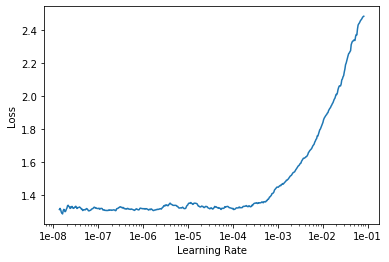

In [13]:
learn.load('stage-2')
learn.unfreeze()
learn.lr_find(start_lr=1e-8, end_lr=1e-1, num_it=500)
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(4, max_lr=slice(1e-5, 8e-5))
learn.save('stage-3.3')

epoch,train_loss,valid_loss,error_rate,time
0,1.303707,1.183726,0.394625,05:40
1,1.180835,1.142704,0.382500,05:44
2,1.089154,1.119465,0.377000,05:44
3,0.994973,1.123123,0.375875,05:45
